In [1]:
#Created by Rekha Sundararajan
# Fan Degradation prediction using the NASA public dataset provided for TurboFan Engine data that has both HPC and Fan degradation and HPC only degradation.
#Import required Libraries
import pandas as pd
import numpy as np
import random
import os
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
np.random.seed(34)

In [2]:
index_names=['unit_number','time_cycles']
setting_names = ['setting_1','setting_2','setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(21)]
col_names  = index_names + setting_names + sensor_names

dftrain1 = pd.read_csv("train_FD001.txt",sep="\s+",header=None,index_col=False,names=col_names)
dftrain3 = pd.read_csv("train_FD003.txt",sep="\s+",header=None,index_col=False,names=col_names)

dftest1 = pd.read_csv("test_FD001.txt",sep="\s+",header=None,index_col=False,names=col_names)
dftest3 = pd.read_csv("test_FD003.txt",sep="\s+",header=None,index_col=False,names=col_names)

y_test1 = pd.read_csv("RUL_FD001.txt",sep="\s+",header=None,index_col=False,names=col_names)
y_test3 = pd.read_csv("RUL_FD003.txt",sep="\s+",header=None,index_col=False,names=col_names)


In [3]:
train1 = dftrain1.copy()
train3 = dftrain3.copy()


In [4]:
def add_EFFICIENCY_column(df):
    train_grouped_by_unit = df.groupby(by='unit_number')
    max_time_cycles = train_grouped_by_unit['time_cycles'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycles'),left_on='unit_number',right_index=True)
    merged['EFFICIENCY'] = 100*((merged['max_time_cycles'] - merged['time_cycles'])/merged['max_time_cycles'])
    merged = merged.drop("max_time_cycles",axis=1)
    return merged


In [5]:
train1 = add_EFFICIENCY_column(train1)
train3 = add_EFFICIENCY_column(train3)


In [6]:
Sensor_dictionary = {}
dict_list=[
    "Fan Inlet Temperature",
    "LPC Outlet Temperature",
    "HPC Outlet Temperature",
    "LPT Outlet Temperature",
    "Fan Inlet Pressure",
    "Bypass-duct Pressure",
    "HPC Outlet Pressure",
    "Physical Fan Speed",
    "Physical Core Speed",
    "Engine pressure ratio",
    "HPC Outlet Static Pressure",
    "Ratio of Fuel Flow to PS30",
    "Corrected Fan Speed",
    "Corrected Core Speed",
    "Bypass ratio",
    "Burner Fuel-air Ratio",
    "Bleed Enthalpy",
    "Required Fan Speed",
    "Required Fan Conversion Speed",
    "High-pressure turbines cool air flow",
    "Low-pressure turbines cool air flow"
]

si = 1
for x in dict_list:
    Sensor_dictionary['s_'+str(si)] = x
    si += 1
Sensor_dictionary

{'s_1': 'Fan Inlet Temperature',
 's_2': 'LPC Outlet Temperature',
 's_3': 'HPC Outlet Temperature',
 's_4': 'LPT Outlet Temperature',
 's_5': 'Fan Inlet Pressure',
 's_6': 'Bypass-duct Pressure',
 's_7': 'HPC Outlet Pressure',
 's_8': 'Physical Fan Speed',
 's_9': 'Physical Core Speed',
 's_10': 'Engine pressure ratio',
 's_11': 'HPC Outlet Static Pressure',
 's_12': 'Ratio of Fuel Flow to PS30',
 's_13': 'Corrected Fan Speed',
 's_14': 'Corrected Core Speed',
 's_15': 'Bypass ratio',
 's_16': 'Burner Fuel-air Ratio',
 's_17': 'Bleed Enthalpy',
 's_18': 'Required Fan Speed',
 's_19': 'Required Fan Conversion Speed',
 's_20': 'High-pressure turbines cool air flow',
 's_21': 'Low-pressure turbines cool air flow'}

In [7]:
def plot_signal(dfr,sensor_dic,signal_name,tlabel):
    plt.figure(figsize=(13,5))
    for i in dfr['unit_number'].unique():  
        if i%5 == 0:
            plt.plot('EFFICIENCY',signal_name,data=dfr[dfr['unit_number'] == i].rolling(10).mean())
    plt.xlim(100,0)
    plt.xticks(np.arange(0,100,20))
    plt.ylabel(sensor_dic[signal_name])
    plt.xlabel('Efficiency')
    plt.title(tlabel)
    plt.show()

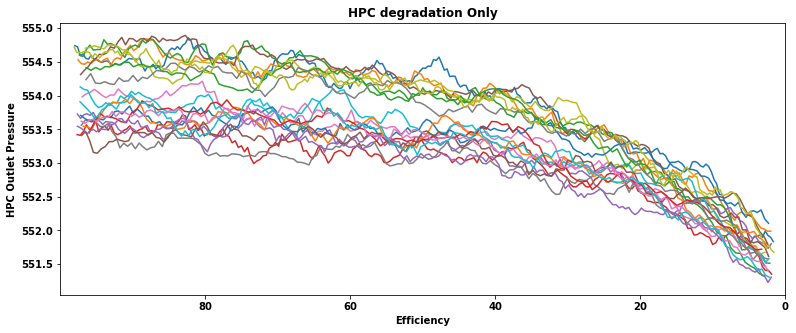

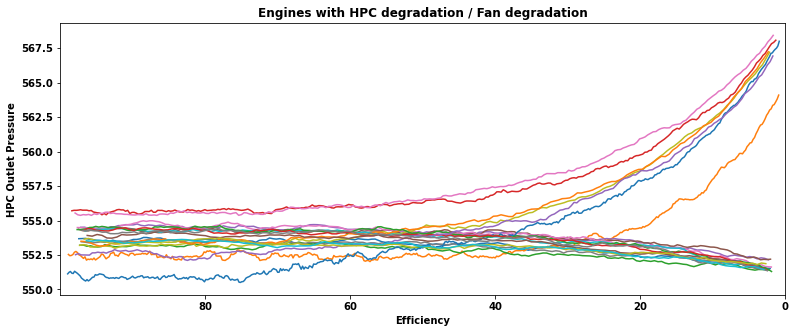

In [8]:
s=[7]
for j in range(0,len(s)):
    try:
        plot_signal(train1,Sensor_dictionary,'s_'+str(s[j]),'HPC degradation Only')
        plot_signal(train3,Sensor_dictionary,'s_'+str(s[j]),'Engines with HPC degradation / Fan degradation')
    except:
        pass


In [9]:
def fandegunitNumList(df):
    # use the HPC outlet pressure > 6 as to have fan degradation specific engines as this dataset has both hpc and fan deg
    
    train_grouped_by_unit = df.groupby(by='unit_number')
    maxs7 = train_grouped_by_unit['s_7'].max()
    mins7 = train_grouped_by_unit['s_7'].min()
    diffce = maxs7 - mins7
    merged = df.merge(diffce.to_frame(name='diffce'),left_on='unit_number',right_index=True)
    
    return merged[merged['diffce'] > 6]['unit_number'].unique()


In [10]:
train1['fan_degradation'] = 0
train3['fan_degradation'] = 1
train_fan = train3[train3['unit_number'].isin(fandegunitNumList(train3))]


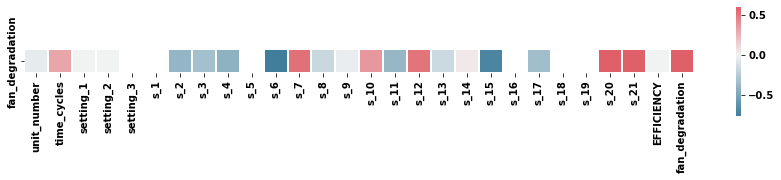

In [11]:
train = pd.concat([train1,train_fan])
corr = train.corr()
#mask = np.triu(np.ones_like(corr,dtype=bool))
f,ax = plt.subplots(figsize=(15,2))
cmap = sns.diverging_palette(230,10,as_cmap=True)
sns.heatmap(corr[corr['fan_degradation'] > 0.7 ],cmap=cmap,vmax=0.6,center=0,square=True,linewidths=0.42)
plt.show()


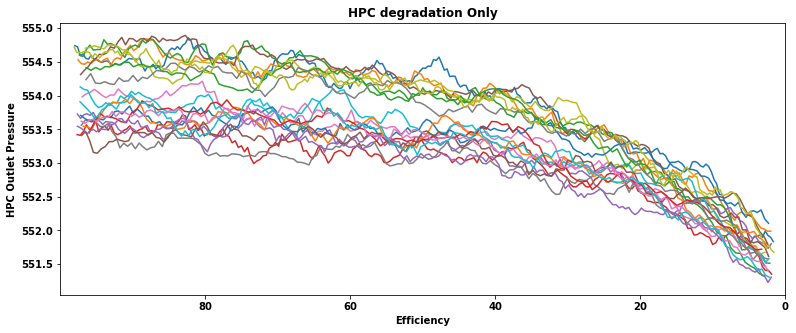

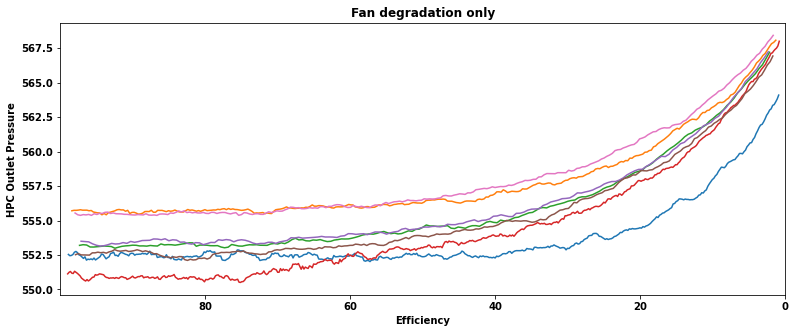

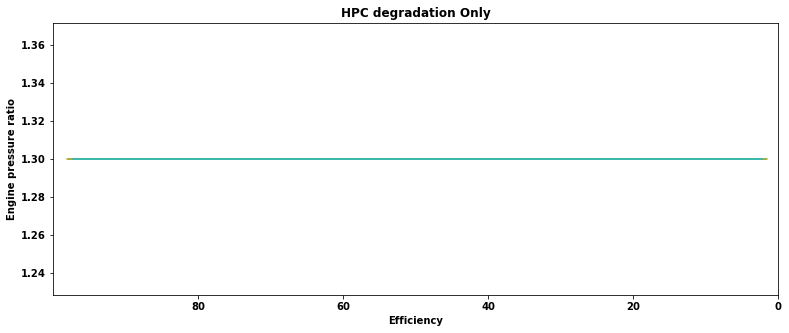

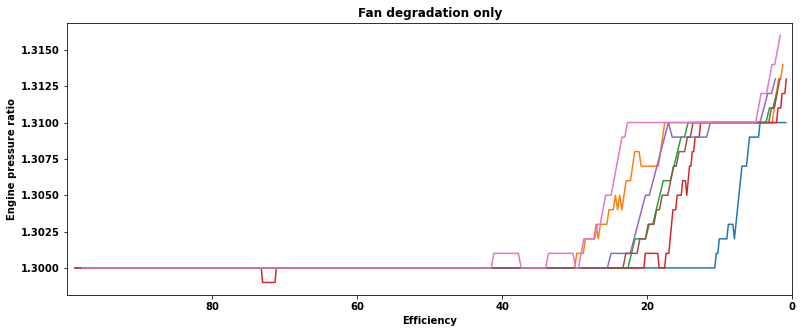

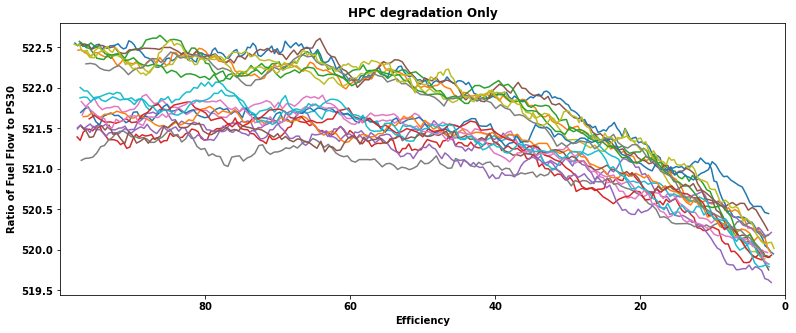

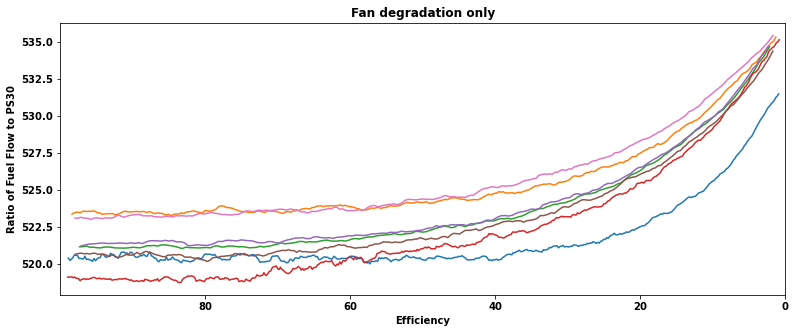

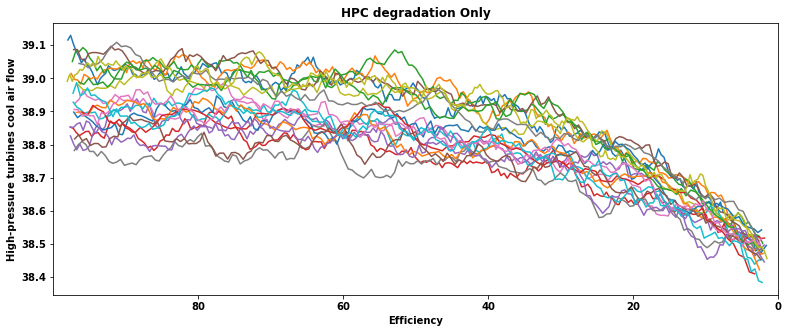

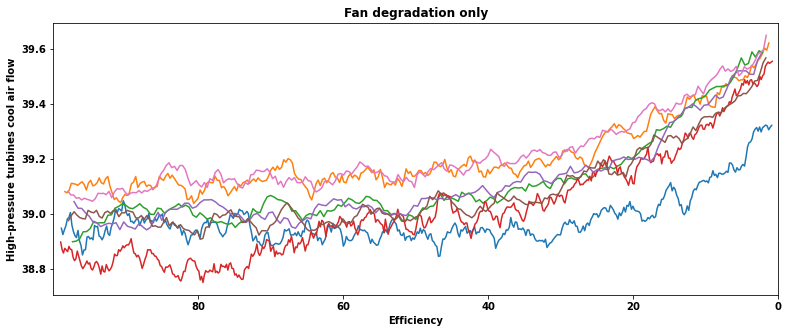

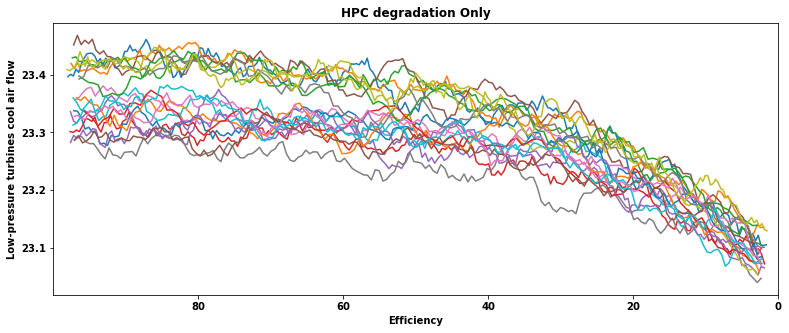

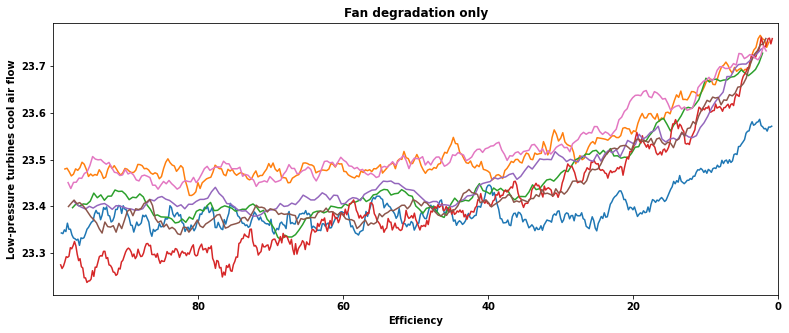

In [12]:
s=[7,10,12,20,21]
for j in range(0,len(s)):
    try:
        plot_signal(train1,Sensor_dictionary,'s_'+str(s[j]),'HPC degradation Only')
        #plot_signal(train3,Sensor_dictionary,'s_'+str(s[j]),'Engines with HPC degradation / Fan degradation')
        plot_signal(train_fan,Sensor_dictionary,'s_'+str(s[j]),'Fan degradation only')
    except:
        pass
